In [1]:
from numpy import *
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import glob
import alsvinn_tools
from plot_info import *
import datetime
import socket
print("Generated on %s on %s" % (datetime.date.today(), socket.gethostname()))
errors=''
historic_date = '2018-12-01'

Generated on 2018-12-02 on galerkin


# Kelvin-Helmholtz

We run the Kelvin-Helmholtz instability for different resolutions

Remember that 2D FVM has a runtime of $$O(N^3)$$. We can not afford to allocate that many CPUs, so we always increase the amount of CPUs by a factor of 4, and measure the time per timestep

## With file output


core_counts['multixmultiymultiz'] = [1, 8, 64, 512]
runtimes['multixmultiymultiz'] = [13000, 35000, 106000, 297000]
runtimes_per_timestep['multixmultiymultiz'] = [7.536231884057971, 9.985734664764623, 14.243482934694974, 20.559324380451336]



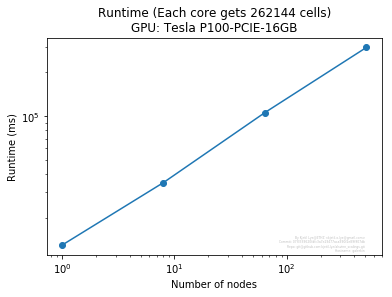

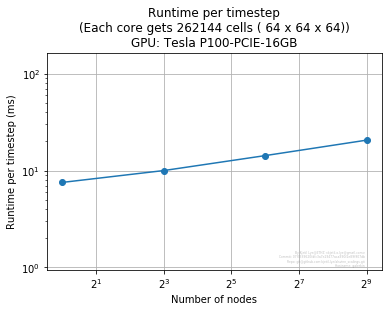

core_counts['multixmultiymultiz'] = [1, 8, 64, 512]
runtimes['multixmultiymultiz'] = [91000, 257000, 635000, 1697000]
runtimes_per_timestep['multixmultiymultiz'] = [23.972602739726028, 32.55224825839139, 39.85188904229948, 56.600627042892405]



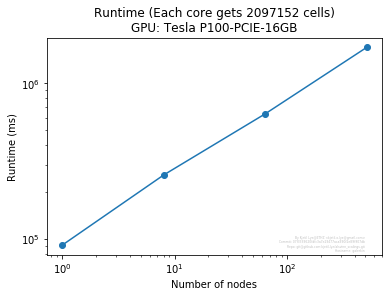

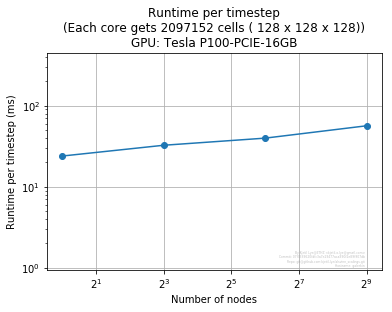

core_counts['multixmultiymultiz'] = [1, 8, 64, 512]
runtimes['multixmultiymultiz'] = [1171000, 2865000, 6044000, 13512000]
runtimes_per_timestep['multixmultiymultiz'] = [141.64751421313656, 174.23827768655354, 190.1705367818262, 227.7124271124743]



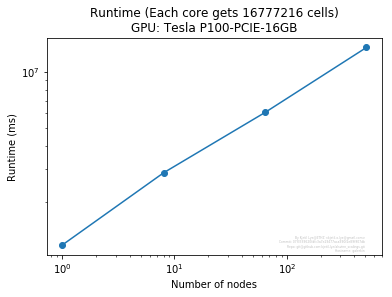

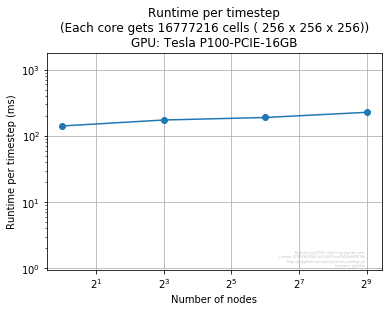

Git revision: a1864525e52f1f03fd2f72a7bda5d2a22a5a2a86
revisions= ['f667b0108553bc2635ce52cc79fcec4c59d95a4b', 'f667b0108553bc2635ce52cc79fcec4c59d95a4b', 'f667b0108553bc2635ce52cc79fcec4c59d95a4b', 'f667b0108553bc2635ce52cc79fcec4c59d95a4b', 'f667b0108553bc2635ce52cc79fcec4c59d95a4b', 'f667b0108553bc2635ce52cc79fcec4c59d95a4b', 'f667b0108553bc2635ce52cc79fcec4c59d95a4b', 'f667b0108553bc2635ce52cc79fcec4c59d95a4b', 'f667b0108553bc2635ce52cc79fcec4c59d95a4b', 'f667b0108553bc2635ce52cc79fcec4c59d95a4b', 'f667b0108553bc2635ce52cc79fcec4c59d95a4b', 'a1864525e52f1f03fd2f72a7bda5d2a22a5a2a86']

build_types: ['Release', 'Release', 'Release', 'Release', 'Release', 'Release', 'Release', 'Release', 'Release', 'Release', 'Release', 'Release']


In [2]:
setups=['multixmultiymultiz']
build_types = []
revisions = []
min_runtime_timestep = None
max_runtime_timestep = None
base_Ns = [64, 128, 256]
for base_N in base_Ns:
    for setup in setups:
        basename = '../historic_runs/daint_{historic_date}/base_{base_N}_3d_{setup}/3d/weak_scaling/kelvinhelmholtz_{N}/alsuqcli_kh_{N}_report.json'

        resolutions = base_N * 2**arange(4)
        runtimes = []
        runtimes_per_timestep = []
        core_counts = []
        
        for resolution in resolutions:
            try:
                report = basename.format(N=resolution, setup = setup, historic_date = historic_date, base_N=base_N)
               
                git_revision = alsvinn_tools.get_revision(report)
                revisions.append(git_revision)
                build_types.append(alsvinn_tools.get_build_type(report))
                runtime = alsvinn_tools.get_runtime(report)
                runtimes.append(runtime)
                gpu = alsvinn_tools.get_gpu_name(report)
                cores = alsvinn_tools.get_total_cores(report)
                core_counts.append(cores)
                
                timesteps = alsvinn_tools.get_timesteps(report)
                runtimes_per_timestep.append(float(runtime)/timesteps)
            except Exception as e:
                errors +="Failed at resolution {N} with {setup}\n\n Skipping\n.".format(N=resolution, setup=setup)
                errors +=str(e) + '\n'
                print(e)
                #raise e
        try:
            if len(runtimes) == 0:
                continue
            plt.figure(0)
            plt.title("Runtime (Each core gets %d cells)\nGPU: %s" % (resolutions[0]**3, gpu))
            plt.loglog(core_counts, runtimes, '-o',label=setup)
            plt.xlabel('Number of nodes')
            plt.ylabel('Runtime (ms)')
            ax = plt.gca()
            #ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        
            
            plt.figure(1)
            plt.title("Runtime per timestep\n(Each core gets %d cells ( %d x %d x %d))\nGPU: %s" % \
                      (resolutions[0]**3, resolutions[0], resolutions[0], resolutions[0], gpu))
            plt.loglog(core_counts, runtimes_per_timestep, '-o',label=setup, basex=2)
            if min_runtime_timestep is None:
                min_runtime_timestep = min(runtimes_per_timestep)
                max_runtime_timestep = max(runtimes_per_timestep)
            else:
                min_runtime_timestep = min(min_runtime_timestep, min(runtimes_per_timestep))
                max_runtime_timestep = max(max_runtime_timestep, max(runtimes_per_timestep))
            plt.ylim([min_runtime_timestep/8, max_runtime_timestep*8])
            plt.xlabel('Number of nodes')
            plt.ylabel('Runtime per timestep (ms)')
            plt.grid(True)
            ax = plt.gca()
            #ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            print("core_counts['%s'] = %s" % (setup, core_counts))
            print("runtimes['%s'] = %s" % (setup, runtimes))
            print("runtimes_per_timestep['%s'] = %s" % (setup, runtimes_per_timestep))
            print("")
        except Exception as e:
            errors += "Failed at {setup}\n\n Skipping.".format(setup=setup) + '\n'
            errors += str(e) + '\n'
            raise e
    
    try:
        plt.figure(0)
        savePlot("weak_scaling_cuda_3d_runtime")
        plt.figure(1)
        savePlot("weak_scaling_cuda_3d_runtime_per_timestep")
        plt.show()
    except Exception as e:
        errors+= str(e)+'\n'
        raise e
try:
   
    
    print("Git revision: %s" % git_revision )
    plt.show()
    print("revisions= %s" % revisions)
    print()
    print("build_types: %s" % build_types)
except Exception as e:
    errors+= str(e)+'\n'
    raise e

## Without file output


core_counts['multixmultiymultiz'] = [1, 8, 64, 512]
runtimes['multixmultiymultiz'] = [12000, 45000, 102000, 225000]
runtimes_per_timestep['multixmultiymultiz'] = [6.956521739130435, 12.838801711840228, 13.722588456881475, 15.566625155666252]



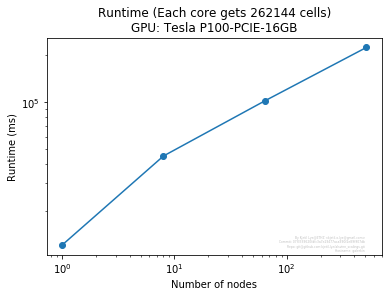

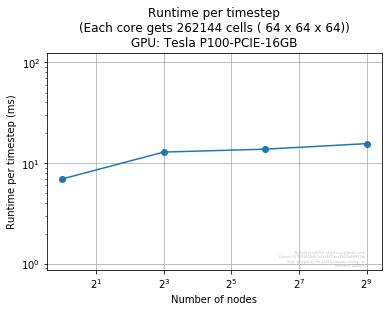

core_counts['multixmultiymultiz'] = [1, 8, 64, 512]
runtimes['multixmultiymultiz'] = [93000, 257000, 607000, 1236000]
runtimes_per_timestep['multixmultiymultiz'] = [24.499473129610116, 32.55224825839139, 38.14731020613374, 41.2]



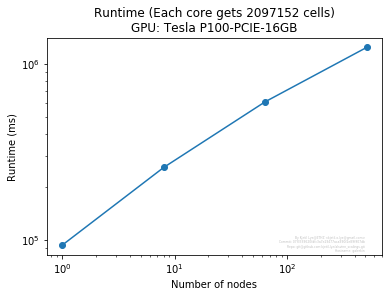

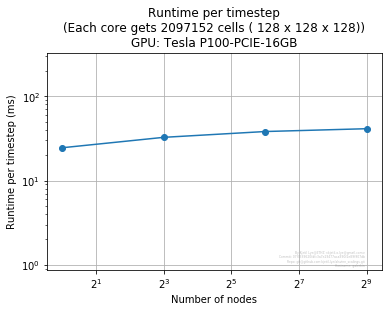

core_counts['multixmultiymultiz'] = [1, 8, 64, 512]
runtimes['multixmultiymultiz'] = [1159000, 2818000, 5611000, 10741000]
runtimes_per_timestep['multixmultiymultiz'] = [140.195959840329, 171.3799185063553, 176.54647284626517, 181.0138528430348]



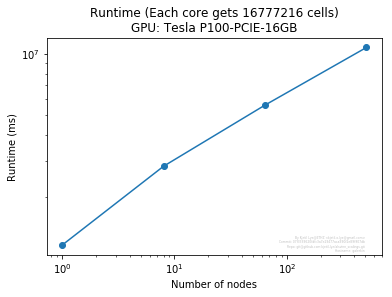

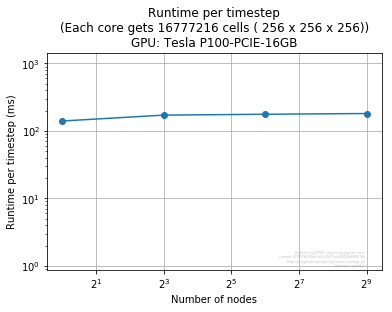

Git revision: a1864525e52f1f03fd2f72a7bda5d2a22a5a2a86
revisions= ['f667b0108553bc2635ce52cc79fcec4c59d95a4b', 'f667b0108553bc2635ce52cc79fcec4c59d95a4b', 'f667b0108553bc2635ce52cc79fcec4c59d95a4b', 'f667b0108553bc2635ce52cc79fcec4c59d95a4b', 'f667b0108553bc2635ce52cc79fcec4c59d95a4b', 'f667b0108553bc2635ce52cc79fcec4c59d95a4b', 'f667b0108553bc2635ce52cc79fcec4c59d95a4b', 'f667b0108553bc2635ce52cc79fcec4c59d95a4b', 'f667b0108553bc2635ce52cc79fcec4c59d95a4b', 'f667b0108553bc2635ce52cc79fcec4c59d95a4b', 'f667b0108553bc2635ce52cc79fcec4c59d95a4b', 'a1864525e52f1f03fd2f72a7bda5d2a22a5a2a86']

build_types: ['Release', 'Release', 'Release', 'Release', 'Release', 'Release', 'Release', 'Release', 'Release', 'Release', 'Release', 'Release']


In [3]:
setups=['multixmultiymultiz']
build_types = []
revisions = []
min_runtime_timestep = None
max_runtime_timestep = None
base_Ns = [64, 128, 256]
for base_N in base_Ns:
    for setup in setups:
        basename = '../historic_runs/daint_{historic_date}/base_{base_N}_3d_{setup}_nowrite/3d/weak_scaling_nowrite/kelvinhelmholtz_{N}/alsuqcli_kh_nowrite_{N}_report.json'

        resolutions = base_N * 2**arange(4)
        runtimes = []
        runtimes_per_timestep = []
        core_counts = []
        
        for resolution in resolutions:
            try:
                report = basename.format(N=resolution, setup = setup, historic_date = historic_date, base_N=base_N)
               
                git_revision = alsvinn_tools.get_revision(report)
                gpu = alsvinn_tools.get_gpu_name(report)
                revisions.append(git_revision)
                build_types.append(alsvinn_tools.get_build_type(report))
                runtime = alsvinn_tools.get_runtime(report)
                runtimes.append(runtime)
                
                cores = alsvinn_tools.get_total_cores(report)
                core_counts.append(cores)
                
                timesteps = alsvinn_tools.get_timesteps(report)
                runtimes_per_timestep.append(float(runtime)/timesteps)
            except Exception as e:
                errors +="Failed at resolution {N} with {setup}\n\n Skipping\n.".format(N=resolution, setup=setup)
                errors +=str(e) + '\n'
                #print(e)
                #raise e
        try:
            if len(runtimes) == 0:
                continue
            plt.figure(0)
            plt.title("Runtime (Each core gets %d cells)\nGPU: %s" % (resolutions[0]**3, gpu))
            plt.loglog(core_counts, runtimes, '-o',label=setup)
            plt.xlabel('Number of nodes')
            plt.ylabel('Runtime (ms)')
            ax = plt.gca()
            #ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        
            
            plt.figure(1)
            plt.title("Runtime per timestep\n(Each core gets %d cells ( %d x %d x %d))\nGPU: %s" % \
                      (resolutions[0]**3, resolutions[0], resolutions[0], resolutions[0], gpu))
            plt.loglog(core_counts, runtimes_per_timestep, '-o',label=setup, basex=2)
            if min_runtime_timestep is None:
                min_runtime_timestep = min(runtimes_per_timestep)
                max_runtime_timestep = max(runtimes_per_timestep)
            else:
                min_runtime_timestep = min(min_runtime_timestep, min(runtimes_per_timestep))
                max_runtime_timestep = max(max_runtime_timestep, max(runtimes_per_timestep))
            plt.ylim([min_runtime_timestep/8, max_runtime_timestep*8])
            plt.xlabel('Number of nodes')
            plt.ylabel('Runtime per timestep (ms)')
            plt.grid(True)
            ax = plt.gca()
            #ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            print("core_counts['%s'] = %s" % (setup, core_counts))
            print("runtimes['%s'] = %s" % (setup, runtimes))
            print("runtimes_per_timestep['%s'] = %s" % (setup, runtimes_per_timestep))
            print("")
        except Exception as e:
            errors += "Failed at {setup}\n\n Skipping.".format(setup=setup) + '\n'
            errors += str(e) + '\n'
            raise e
    
    try:
        plt.figure(0)
        savePlot("weak_scaling_cuda_nowrite_3d_runtime")
        plt.figure(1)
        savePlot("weak_scaling_cuda_nowrite_3d_runtime_per_timestep")
        plt.show()
    except Exception as e:
        errors+= str(e)+'\n'
        raise e
try:
   
    
    print("Git revision: %s" % git_revision )
   
    print("revisions= %s" % revisions)
    print()
    print("build_types: %s" % build_types)
except Exception as e:
    errors+= str(e)+'\n'
    raise e

In [4]:
import os
cmakeCache = '../alsvinn/build/CMakeCache.txt'
if os.path.exists(cmakeCache):
    with open(cmakeCache, 'r') as f:
        print(f.read())

In [5]:
print(errors)